In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
image_dir = Path(r"D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset")

Buat File Dataframe

In [3]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    # Ambil sampel dari setiap kategori dengan maksimum 600 gambar
    category_samples.append(category_slice.sample(min(2000, len(category_slice)), random_state=1, replace=False))

image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)


In [4]:
image_df

,Filepath,Label
0,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Buras
1,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Sop Konro
2,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Sop Konro
3,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Kapurung
4,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Kapurung
...,...,...
5881,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Buras
5882,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Sop Konro
5883,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Sokko
5884,D:\Kuliah Semester 6\Jurnal\Materi\CNN\Dataset...,Buras


In [5]:
image_df['Label'].value_counts()

Label
Sop Konro    1217
Kapurung     1153
Buras        1129
Dangkot       889
Sokko         875
Gogos         623
Name: count, dtype: int64

In [6]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

Buat Train Generator

In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [8]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3296 validated image filenames belonging to 6 classes.
Found 824 validated image filenames belonging to 6 classes.
Found 1766 validated image filenames belonging to 6 classes.


Modelling

In [9]:
pretrained_model = DenseNet169(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
    classifier_activation = 'softmax'
)

pretrained_model.trainable = False

In [10]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(6, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


#print(model.summary())

Training

In [11]:
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [12]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
        f1_score,
    ]
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=30,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
) 

Epoch 1/30


c:\Program Files\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


103/103 ━━━━━━━━━━━━━━━━━━━━ 366s 3s/step - accuracy: 0.7943 - auc: 0.6019 - f1_score: 0.1884 - loss: 3.1379 - precision: 0.2886 - recall: 0.1436 - val_accuracy: 0.8422 - val_auc: 0.7948 - val_f1_score: 0.3003 - val_loss: 1.4071 - val_precision: 0.5738 - val_recall: 0.2075
Epoch 2/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 386s 4s/step - accuracy: 0.8451 - auc: 0.8002 - f1_score: 0.3317 - loss: 1.3991 - precision: 0.5883 - recall: 0.2345 - val_accuracy: 0.8548 - val_auc: 0.8470 - val_f1_score: 0.3835 - val_loss: 1.2286 - val_precision: 0.6523 - val_recall: 0.2755
Epoch 3/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 395s 4s/step - accuracy: 0.8640 - auc: 0.8544 - f1_score: 0.4644 - loss: 1.1953 - precision: 0.6733 - recall: 0.3576 - val_accuracy: 0.8667 - val_auc: 0.8658 - val_f1_score: 0.5134 - val_loss: 1.1641 - val_precision: 0.6548 - val_recall: 0.4235
Epoch 4/30
103/103 ━━━━━━━━━━━━━━━━━━━━ 400s 4s/step - accuracy: 0.8748 - auc: 0.8730 - f1_score: 0.5256 - loss: 1.1206 - precision: 0.7092 - recall: 0.4218

Result

In [13]:
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 88.78%


In [14]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

56/56 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step


In [15]:
#%% PLOTTING RESULTS (Train vs Validation)
import matplotlib.pyplot as plt 
def Train_Val_plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision, f1, val_f1):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(20, 5))
    fig.suptitle("VISUALIZE THE PERFORMANCE MATRICS")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1 Score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 Score')
    ax5.legend(['training', 'validation'])
    plt.show()


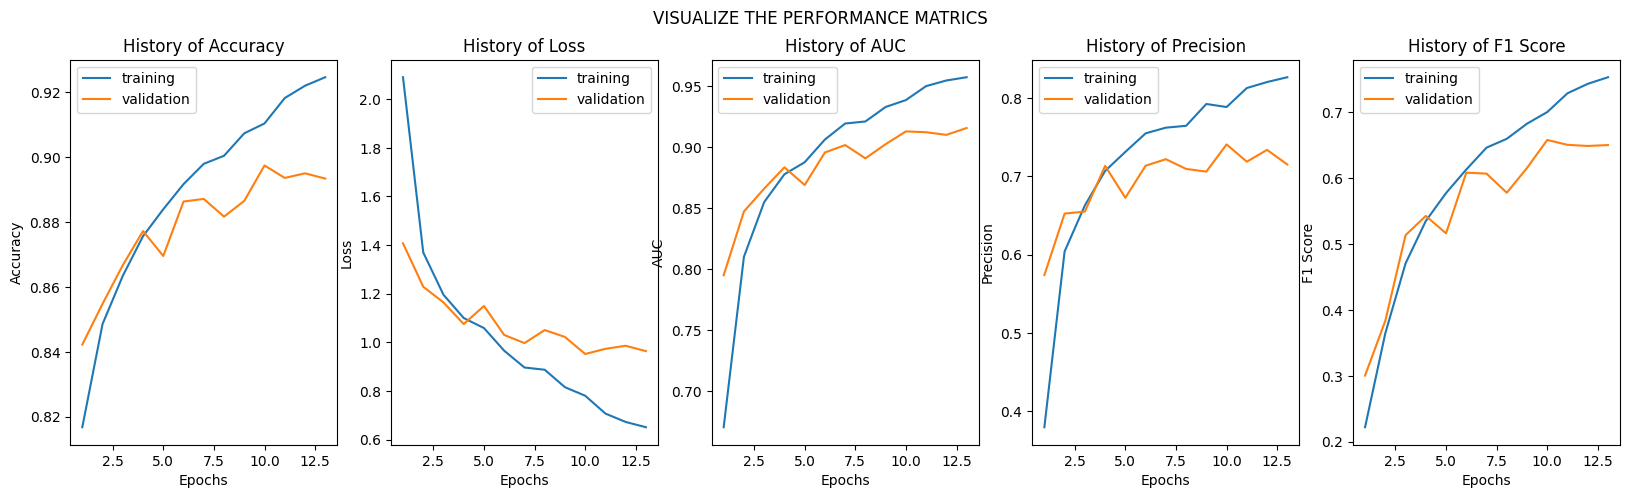

In [16]:
Train_Val_plot(history.history['accuracy'], history.history['val_accuracy'],
               history.history['loss'], history.history['val_loss'],
               history.history['auc'], history.history['val_auc'],
               history.history['precision'], history.history['val_precision'],
               history.history['f1_score'], history.history['val_f1_score'])

In [17]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
               precision    recall  f1-score   support

       Buras       0.63      0.68      0.66       358
     Dangkot       0.55      0.61      0.58       218
       Gogos       0.68      0.47      0.55       215
    Kapurung       0.65      0.71      0.68       328
       Sokko       0.77      0.54      0.64       248
   Sop Konro       0.63      0.73      0.67       399

    accuracy                           0.64      1766
   macro avg       0.65      0.62      0.63      1766
weighted avg       0.65      0.64      0.64      1766



In [18]:
# Saving the model
model.save('DenseNet-1.h5')

Deteksi

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predictions shape: (1, 6)
Predicted class: Gogos


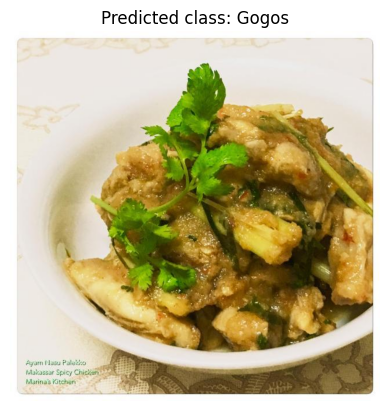

In [20]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
from keras.applications.mobilenet_v2 import preprocess_input
import matplotlib.pyplot as plt

# Load the custom MobileNetV2 model
model = load_model("D:\Kuliah Semester 6\Jurnal\Materi\CNN\Codingan\DenseNet-1.h5")

# Define the class names
class_names = ['Buras', 'Dangkot', 'Gogos', 'Kapurung', 'Sokko', 'Sop Konro']

# Define the path to your image
image_path = r"D:\Kuliah Semester 6\Jurnal\Materi\CNN\Split_dataset\test\Dangkot\DANGKOT_79.jpg"

# Load and preprocess the image
img = image.load_img(image_path, target_size=(224, 224))  # Sesuaikan ukuran dengan ukuran input model Anda
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Make prediction
preds = model.predict(x)

# Check the shape of the predictions
print("Predictions shape:", preds.shape)

# Get the index of the highest probability prediction
pred_index = np.argmax(preds)

# Initialize the predicted class variable
predicted_class = "Predicted index is out of range"

# Check if pred_index is within the range of class_names
if pred_index < len(class_names):
    # Get the predicted class label
    predicted_class = class_names[pred_index]

# Print the predicted class label
print("Predicted class:", predicted_class)

# Display the image along with the predicted class
plt.imshow(image.load_img(image_path))
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()